In [1]:
import torchio
import torch
import pandas as pd
from model import MRINet
from tqdm import tqdm
from training_loop import SaveBestModelLoss
from scans_preparation.utils import rescale_intensity, equalize_hist
import matplotlib.pyplot as plt

In [2]:
transforms = torchio.Compose(
    [
        torchio.ToCanonical(p=1.0),
        torchio.CropOrPad(target_shape=(210, 210, 210), p=1.0),
        torchio.Resize(target_shape=(128,128,128)),
    ]
)
augmentations = torchio.Compose(
    [
        torchio.RandomFlip(axes=(0, 1, 2), p=0.5),
        torchio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=20, isotropic=True, p=0.5),
        torchio.RandomNoise(std=(0, 0.1), p=0.5),
        torchio.RandomBlur(std=(0, 0.5), p=0.5),
        torchio.RandomMotion(p=0.3),
        torchio.RandomSpike(p=0.3),
        torchio.RandomGhosting(p=0.3),
        torchio.RandomSwap(patch_size=10, num_iterations=15, p=1.0),
        torchio.Clamp(0,1)
    ]
)

def augment_batched(images_batch: torch.Tensor) -> torch.Tensor:
    for i in range(images_batch.shape[0]):
        images_batch[i] = augmentations(images_batch[i])
    return images_batch

def normalize_batched(images_batch: torch.Tensor) -> torch.Tensor:
    for i in range(images_batch.shape[0]):
        image = rescale_intensity(images_batch[i].numpy())
        image = equalize_hist(image)
        images_batch[i] = torch.Tensor(image / 255)
    return images_batch

dataset = torchio.datasets.ixi.IXI(root=r"/home/dpolak/MRI/", transform=transforms, modalities=["T1"], download=True)

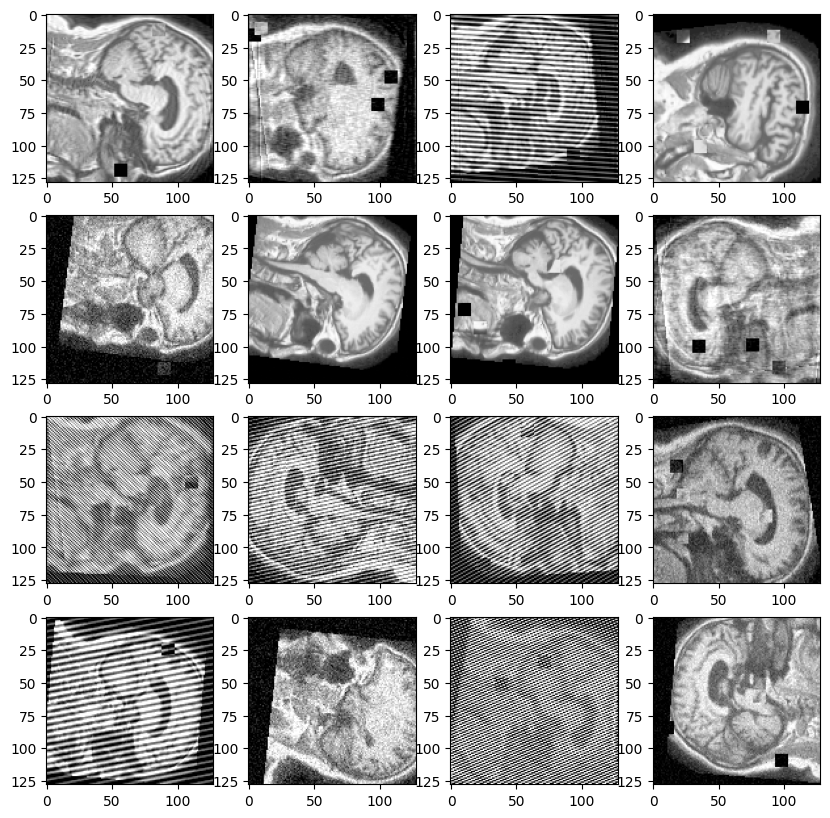

In [15]:
plt.figure(figsize=(10,10))
for i in range(16):
    image = equalize_hist(rescale_intensity(dataset[5]["T1"].numpy())) / 255
    image = augmentations(image)
    plt.subplot(4, 4, i+1)
    plt.imshow(image[0, 60, :, :], cmap="gray")

In [16]:
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [0.9, 0.1])

In [17]:
demographic_data = pd.read_excel(r"/home/dpolak/Downloads/IXI.xls")  # download this file from https://brain-development.org/ixi-dataset/

In [18]:
demographic_data = demographic_data[["IXI_ID", "SEX_ID (1=m, 2=f)", "AGE"]].dropna()

In [19]:
def get_ground_truth(subject_id: str) -> tuple[int, float]:
    subject_number = int(subject_id.split("-")[0].replace("IXI", ""))
    row = demographic_data[demographic_data["IXI_ID"] == subject_number]
    return row["SEX_ID (1=m, 2=f)"].values[0] - 1, row["AGE"].values[0]

In [20]:
model = MRINet(num_classes=2, pretrain=True).to("cuda")

In [21]:
batch_size = 10
num_epochs = 30

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_ce = torch.nn.BCEWithLogitsLoss()
criterion_mse = torch.nn.MSELoss()
save_best = SaveBestModelLoss(save_path="models/pretrained")
history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(num_epochs):
    train_acc, train_mse, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, drop_last=True), leave=True)
    model.train()
    i = 1
    for batch in prbar:
        try:
            labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]]).float()
        except IndexError:
            continue
        inputs = batch["T1"][torchio.DATA].float()
        inputs = normalize_batched(inputs)
        inputs = augment_batched(inputs)
        optimizer.zero_grad()
        output_0, output_1 = model(inputs.to("cuda"))
        output_0 = output_0.squeeze()
        output_1 = output_1.squeeze()
        ce = criterion_ce(output_0.to("cpu"), labels[:, 0])
        mse = criterion_mse(output_1.to("cpu"), labels[:, 1])
        loss = ce + mse
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        prbar.set_description(
                f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                f"Train MSE: {round(train_mse / (i * batch_size), 3)}, "
                f"Running Loss: {round(running_loss / i, 3)}")
        i += 1
    history["train_loss"].append(running_loss / i)
    model.eval()
    with torch.no_grad():

        i = 1
        prbar = tqdm(torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, drop_last=True), leave=True)
        for batch in prbar:
            try:
                labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]])
            except IndexError:
                continue
            inputs = batch["T1"][torchio.DATA].float()
            inputs = normalize_batched(inputs)
            output_0, output_1 = model(inputs.to("cuda"))
            output_0 = output_0.squeeze()
            output_1 = output_1.squeeze()
            ce = criterion_ce(output_0.to("cpu"), labels[:, 0])
            mse = criterion_mse(output_1.to("cpu"), labels[:, 1])
            val_mse += mse.item()
            loss = ce + mse
            val_running_loss += loss.item()
            prbar.set_description(
                            f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                            f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                            f"Valid MSE: {round(val_mse / (i * batch_size), 3)}, "
                            f"Running Loss: {round(val_running_loss / i, 3)}"
            )
            i += 1
        history["val_loss"].append(val_running_loss / i)
    save_best(val_running_loss, epoch, model)

Epoch: 0, Step loss: 145.012, Step MSE: 14.379, Train MSE: 60.081, Running Loss: 601.991: 100%|███████████████████████████████████████████████████| 52/52 [03:03<00:00,  3.52s/it]
Epoch: 0, Step loss: 353.474, Step MSE: 35.261, Valid MSE: 29.108, Running Loss: 291.872: 100%|█████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]



Best validation loss: 875.6173052987485

Saving best model for epoch: 1



Epoch: 1, Step loss: 282.311, Step MSE: 28.115, Train MSE: 28.301, Running Loss: 284.181: 100%|███████████████████████████████████████████████████| 52/52 [03:01<00:00,  3.50s/it]
Epoch: 1, Step loss: 339.794, Step MSE: 33.909, Valid MSE: 28.364, Running Loss: 284.334: 100%|█████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.60s/it]



Best validation loss: 853.0008062654117

Saving best model for epoch: 2



Epoch: 2, Step loss: 227.114, Step MSE: 22.573, Train MSE: 29.556, Running Loss: 296.51: 100%|████████████████████████████████████████████████████| 52/52 [03:02<00:00,  3.51s/it]
Epoch: 2, Step loss: 387.654, Step MSE: 38.69, Valid MSE: 31.821, Running Loss: 318.906: 100%|██████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]
Epoch: 3, Step loss: 181.562, Step MSE: 18.07, Train MSE: 27.173, Running Loss: 272.728: 100%|████████████████████████████████████████████████████| 52/52 [03:00<00:00,  3.47s/it]
Epoch: 3, Step loss: 378.196, Step MSE: 37.737, Valid MSE: 30.045, Running Loss: 301.208: 100%|█████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]
Epoch: 4, Step loss: 265.868, Step MSE: 26.48, Train MSE: 28.668, Running Loss: 287.677: 100%|████████████████████████████████████████████████████| 52/52 [03:22<00:00,  3.90s/it]
Epoch: 4, Step loss: 292.772, Step MSE: 29.197, Valid MSE: 23.225, Running Loss: 233.01: 100%|███████████


Best validation loss: 699.0289227028666

Saving best model for epoch: 5



Epoch: 5, Step loss: 240.809, Step MSE: 23.992, Train MSE: 27.17, Running Loss: 272.673: 100%|████████████████████████████████████████████████████| 52/52 [03:16<00:00,  3.77s/it]
Epoch: 5, Step loss: 338.04, Step MSE: 33.702, Valid MSE: 28.045, Running Loss: 281.392: 100%|██████████████████████████████████████████████████████| 5/5 [00:14<00:00,  3.00s/it]
Epoch: 6, Step loss: 236.369, Step MSE: 23.493, Train MSE: 27.027, Running Loss: 271.336: 100%|███████████████████████████████████████████████████| 52/52 [03:03<00:00,  3.53s/it]
Epoch: 6, Step loss: 258.505, Step MSE: 25.743, Valid MSE: 21.437, Running Loss: 215.362: 100%|█████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]



Best validation loss: 646.0869905903246

Saving best model for epoch: 7



Epoch: 7, Step loss: 183.858, Step MSE: 18.31, Train MSE: 26.639, Running Loss: 267.311: 100%|████████████████████████████████████████████████████| 52/52 [03:02<00:00,  3.51s/it]
Epoch: 7, Step loss: 246.695, Step MSE: 24.58, Valid MSE: 19.953, Running Loss: 200.363: 100%|██████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]



Best validation loss: 601.0893442250576

Saving best model for epoch: 8



Epoch: 8, Step loss: 180.971, Step MSE: 17.985, Train MSE: 27.253, Running Loss: 273.408: 100%|███████████████████████████████████████████████████| 52/52 [03:00<00:00,  3.48s/it]
Epoch: 8, Step loss: 269.14, Step MSE: 26.823, Valid MSE: 23.275, Running Loss: 233.589: 100%|██████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.70s/it]
Epoch: 9, Step loss: 237.789, Step MSE: 23.693, Train MSE: 27.074, Running Loss: 271.53: 100%|████████████████████████████████████████████████████| 52/52 [03:01<00:00,  3.49s/it]
Epoch: 9, Step loss: 255.062, Step MSE: 25.421, Valid MSE: 19.072, Running Loss: 191.497: 100%|█████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.66s/it]



Best validation loss: 574.4907343322737

Saving best model for epoch: 10



Epoch: 10, Step loss: 199.865, Step MSE: 19.91, Train MSE: 25.445, Running Loss: 255.284: 100%|███████████████████████████████████████████████████| 52/52 [03:00<00:00,  3.46s/it]
Epoch: 10, Step loss: 348.606, Step MSE: 34.768, Valid MSE: 31.158, Running Loss: 312.438: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]
Epoch: 11, Step loss: 172.439, Step MSE: 17.143, Train MSE: 26.269, Running Loss: 263.515: 100%|██████████████████████████████████████████████████| 52/52 [03:02<00:00,  3.51s/it]
Epoch: 11, Step loss: 288.749, Step MSE: 28.786, Valid MSE: 23.862, Running Loss: 239.468: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]
Epoch: 12, Step loss: 150.833, Step MSE: 15.006, Train MSE: 26.854, Running Loss: 269.342: 100%|██████████████████████████████████████████████████| 52/52 [03:02<00:00,  3.50s/it]
Epoch: 12, Step loss: 215.437, Step MSE: 21.469, Valid MSE: 16.865, Running Loss: 169.347: 100%|█████████


Best validation loss: 508.04218598398086

Saving best model for epoch: 13



Epoch: 13, Step loss: 135.313, Step MSE: 13.456, Train MSE: 26.455, Running Loss: 265.299: 100%|██████████████████████████████████████████████████| 52/52 [03:00<00:00,  3.47s/it]
Epoch: 13, Step loss: 258.585, Step MSE: 25.783, Valid MSE: 20.05, Running Loss: 201.218: 100%|█████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]
Epoch: 14, Step loss: 144.297, Step MSE: 14.345, Train MSE: 24.331, Running Loss: 244.083: 100%|██████████████████████████████████████████████████| 52/52 [03:00<00:00,  3.48s/it]
Epoch: 14, Step loss: 174.692, Step MSE: 17.397, Valid MSE: 14.304, Running Loss: 143.713: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]



Best validation loss: 431.13825757535824

Saving best model for epoch: 15



Epoch: 15, Step loss: 259.43, Step MSE: 25.855, Train MSE: 24.563, Running Loss: 246.382: 100%|███████████████████████████████████████████████████| 52/52 [03:01<00:00,  3.49s/it]
Epoch: 15, Step loss: 306.181, Step MSE: 30.542, Valid MSE: 25.746, Running Loss: 258.176: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]
Epoch: 16, Step loss: 229.453, Step MSE: 22.855, Train MSE: 23.37, Running Loss: 234.484: 100%|███████████████████████████████████████████████████| 52/52 [03:01<00:00,  3.49s/it]
Epoch: 16, Step loss: 269.896, Step MSE: 26.906, Valid MSE: 21.256, Running Loss: 213.358: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]
Epoch: 17, Step loss: 180.233, Step MSE: 17.933, Train MSE: 23.391, Running Loss: 234.668: 100%|██████████████████████████████████████████████████| 52/52 [03:01<00:00,  3.49s/it]
Epoch: 17, Step loss: 277.646, Step MSE: 27.676, Valid MSE: 21.98, Running Loss: 220.645: 100%|██████████


Best validation loss: 387.1562623488427

Saving best model for epoch: 28



Epoch: 28, Step loss: 139.2, Step MSE: 13.852, Train MSE: 22.146, Running Loss: 222.154: 100%|████████████████████████████████████████████████████| 52/52 [03:01<00:00,  3.49s/it]
Epoch: 28, Step loss: 151.766, Step MSE: 15.104, Valid MSE: 12.454, Running Loss: 125.276: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]



Best validation loss: 375.82830157202216

Saving best model for epoch: 29



Epoch: 29, Step loss: 114.208, Step MSE: 11.364, Train MSE: 20.594, Running Loss: 206.656: 100%|██████████████████████████████████████████████████| 52/52 [03:00<00:00,  3.48s/it]
Epoch: 29, Step loss: 153.837, Step MSE: 15.315, Valid MSE: 13.778, Running Loss: 138.487: 100%|████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


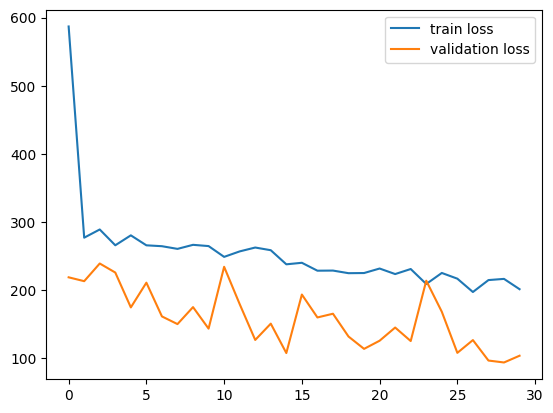

In [23]:
#plot history
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [12]:
model = MRINet(num_classes=2, use_multiscale_stem=True, pretrain=True).to("cuda")

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_ce = torch.nn.BCEWithLogitsLoss()
criterion_mse = torch.nn.MSELoss()
save_best = SaveBestModelLoss(save_path="models/pretrained_multiscale")
history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(num_epochs):
    train_acc, train_mse, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, drop_last=True), leave=True)
    model.train()
    i = 1
    for batch in prbar:
        try:
            labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]]).float()
        except IndexError:
            continue
        inputs = batch["T1"][torchio.DATA].float()
        inputs = normalize_batched(inputs)
        inputs = augment_batched(inputs)
        optimizer.zero_grad()
        output_0, output_1 = model(inputs.to("cuda"))
        output_0 = output_0.squeeze()
        output_1 = output_1.squeeze()
        ce = criterion_ce(output_0.to("cpu"), labels[:, 0])
        mse = criterion_mse(output_1.to("cpu"), labels[:, 1])
        loss = ce + mse
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        prbar.set_description(
                f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                f"Train MSE: {round(train_mse / (i * batch_size), 3)}, "
                f"Running Loss: {round(running_loss / i, 3)}")
        i += 1
    history["train_loss"].append(running_loss / i)
    model.eval()
    with torch.no_grad():

        i = 1
        prbar = tqdm(torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, drop_last=True), leave=True)
        for batch in prbar:
            try:
                labels = torch.tensor([get_ground_truth(subject_id) for subject_id in batch["subject_id"]])
            except IndexError:
                continue
            inputs = batch["T1"][torchio.DATA].float()
            inputs = normalize_batched(inputs)
            output_0, output_1 = model(inputs.to("cuda"))
            output_0 = output_0.squeeze()
            output_1 = output_1.squeeze()
            ce = criterion_ce(output_0.to("cpu"), labels[:, 0])
            mse = criterion_mse(output_1.to("cpu"), labels[:, 1])
            val_mse += mse.item()
            loss = ce + mse
            val_running_loss += loss.item()
            prbar.set_description(
                            f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                            f"Step MSE: {round(mse.item() / batch_size, 3)}, "
                            f"Valid MSE: {round(val_mse / (i * batch_size), 3)}, "
                            f"Running Loss: {round(val_running_loss / i, 3)}"
            )
            i += 1
        history["val_loss"].append(val_running_loss / i)
    save_best(val_running_loss, epoch, model)

Epoch: 0, Step loss: 386.111, Step MSE: 38.467, Train MSE: 52.642, Running Loss: 527.469: 100%|███████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.36s/it]
Epoch: 0, Step loss: 598.832, Step MSE: 59.842, Valid MSE: 43.455, Running Loss: 435.26: 100%|██████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.08s/it]



Best validation loss: 1741.0390986715875

Saving best model for epoch: 1



Epoch: 1, Step loss: 249.82, Step MSE: 24.885, Train MSE: 31.189, Running Loss: 312.865: 100%|████████████████████████████████████████████████████| 52/52 [02:52<00:00,  3.32s/it]
Epoch: 1, Step loss: 377.741, Step MSE: 37.66, Valid MSE: 29.414, Running Loss: 295.023: 100%|██████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.99s/it]



Best validation loss: 1180.090304400512

Saving best model for epoch: 2



Epoch: 2, Step loss: 324.306, Step MSE: 32.362, Train MSE: 28.882, Running Loss: 289.792: 100%|███████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.33s/it]
Epoch: 2, Step loss: 369.319, Step MSE: 36.851, Valid MSE: 29.064, Running Loss: 291.39: 100%|██████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.07s/it]



Best validation loss: 1165.561487078485

Saving best model for epoch: 3



Epoch: 3, Step loss: 266.164, Step MSE: 26.538, Train MSE: 30.226, Running Loss: 303.237: 100%|███████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.36s/it]
Epoch: 3, Step loss: 350.715, Step MSE: 34.999, Valid MSE: 28.363, Running Loss: 284.318: 100%|█████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]



Best validation loss: 1137.2722919240744

Saving best model for epoch: 4



Epoch: 4, Step loss: 305.561, Step MSE: 30.447, Train MSE: 27.877, Running Loss: 279.759: 100%|███████████████████████████████████████████████████| 52/52 [02:55<00:00,  3.37s/it]
Epoch: 4, Step loss: 329.166, Step MSE: 32.83, Valid MSE: 28.473, Running Loss: 285.501: 100%|██████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.10s/it]
Epoch: 5, Step loss: 287.057, Step MSE: 28.606, Train MSE: 28.985, Running Loss: 290.791: 100%|███████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.33s/it]
Epoch: 5, Step loss: 324.799, Step MSE: 32.424, Valid MSE: 29.046, Running Loss: 291.16: 100%|██████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.94s/it]
Epoch: 6, Step loss: 444.064, Step MSE: 44.314, Train MSE: 28.82, Running Loss: 289.075: 100%|████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.33s/it]
Epoch: 6, Step loss: 349.221, Step MSE: 34.849, Valid MSE: 32.45, Running Loss: 325.213: 100%|███████████


Best validation loss: 1130.7232797071078

Saving best model for epoch: 8



Epoch: 8, Step loss: 273.063, Step MSE: 27.23, Train MSE: 27.766, Running Loss: 278.508: 100%|████████████████████████████████████████████████████| 52/52 [02:56<00:00,  3.40s/it]
Epoch: 8, Step loss: 356.247, Step MSE: 35.538, Valid MSE: 27.261, Running Loss: 273.38: 100%|██████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]



Best validation loss: 1093.5215532104658

Saving best model for epoch: 9



Epoch: 9, Step loss: 360.959, Step MSE: 36.01, Train MSE: 27.5, Running Loss: 275.825: 100%|██████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.33s/it]
Epoch: 9, Step loss: 361.163, Step MSE: 36.037, Valid MSE: 25.657, Running Loss: 257.289: 100%|█████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.08s/it]



Best validation loss: 1029.1557813733243

Saving best model for epoch: 10



Epoch: 10, Step loss: 263.602, Step MSE: 26.292, Train MSE: 26.449, Running Loss: 265.274: 100%|██████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]
Epoch: 10, Step loss: 342.332, Step MSE: 34.153, Valid MSE: 26.101, Running Loss: 261.713: 100%|████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.07s/it]
Epoch: 11, Step loss: 282.52, Step MSE: 28.194, Train MSE: 27.71, Running Loss: 277.862: 100%|████████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]
Epoch: 11, Step loss: 349.702, Step MSE: 34.912, Valid MSE: 25.249, Running Loss: 253.11: 100%|█████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.06s/it]



Best validation loss: 1012.439590959404

Saving best model for epoch: 12



Epoch: 12, Step loss: 228.652, Step MSE: 22.789, Train MSE: 25.886, Running Loss: 259.636: 100%|██████████████████████████████████████████████████| 52/52 [02:52<00:00,  3.31s/it]
Epoch: 12, Step loss: 323.333, Step MSE: 32.277, Valid MSE: 28.594, Running Loss: 286.581: 100%|████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.08s/it]
Epoch: 13, Step loss: 283.237, Step MSE: 28.258, Train MSE: 25.979, Running Loss: 260.572: 100%|██████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]
Epoch: 13, Step loss: 331.397, Step MSE: 33.082, Valid MSE: 24.278, Running Loss: 243.433: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.95s/it]



Best validation loss: 973.7302301494724

Saving best model for epoch: 14



Epoch: 14, Step loss: 317.689, Step MSE: 31.69, Train MSE: 27.139, Running Loss: 272.162: 100%|███████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]
Epoch: 14, Step loss: 328.574, Step MSE: 32.792, Valid MSE: 24.494, Running Loss: 245.576: 100%|████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.06s/it]
Epoch: 15, Step loss: 211.096, Step MSE: 21.017, Train MSE: 25.437, Running Loss: 255.119: 100%|██████████████████████████████████████████████████| 52/52 [02:55<00:00,  3.37s/it]
Epoch: 15, Step loss: 328.862, Step MSE: 32.825, Valid MSE: 23.306, Running Loss: 233.692: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]



Best validation loss: 934.7661014950073

Saving best model for epoch: 16



Epoch: 16, Step loss: 304.316, Step MSE: 30.374, Train MSE: 23.689, Running Loss: 237.639: 100%|██████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.36s/it]
Epoch: 16, Step loss: 363.307, Step MSE: 36.275, Valid MSE: 22.805, Running Loss: 228.668: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]



Best validation loss: 914.6701436525253

Saving best model for epoch: 17



Epoch: 17, Step loss: 251.393, Step MSE: 25.059, Train MSE: 24.505, Running Loss: 245.768: 100%|██████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]
Epoch: 17, Step loss: 324.159, Step MSE: 32.342, Valid MSE: 25.238, Running Loss: 253.086: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.98s/it]
Epoch: 18, Step loss: 171.317, Step MSE: 17.051, Train MSE: 24.286, Running Loss: 243.592: 100%|██████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]
Epoch: 18, Step loss: 305.485, Step MSE: 30.475, Valid MSE: 23.466, Running Loss: 235.333: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.98s/it]
Epoch: 19, Step loss: 157.536, Step MSE: 15.677, Train MSE: 24.321, Running Loss: 243.955: 100%|██████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.33s/it]
Epoch: 19, Step loss: 288.886, Step MSE: 28.826, Valid MSE: 24.29, Running Loss: 243.537: 100%|██████████


Best validation loss: 875.8089712257099

Saving best model for epoch: 21



Epoch: 21, Step loss: 205.071, Step MSE: 20.433, Train MSE: 23.609, Running Loss: 236.841: 100%|██████████████████████████████████████████████████| 52/52 [02:51<00:00,  3.29s/it]
Epoch: 21, Step loss: 386.495, Step MSE: 38.575, Valid MSE: 25.793, Running Loss: 258.618: 100%|████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.12s/it]
Epoch: 22, Step loss: 173.854, Step MSE: 17.31, Train MSE: 24.344, Running Loss: 244.155: 100%|███████████████████████████████████████████████████| 52/52 [02:51<00:00,  3.29s/it]
Epoch: 22, Step loss: 300.711, Step MSE: 30.007, Valid MSE: 27.801, Running Loss: 278.636: 100%|████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.06s/it]
Epoch: 23, Step loss: 214.088, Step MSE: 21.324, Train MSE: 21.201, Running Loss: 212.713: 100%|██████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.36s/it]
Epoch: 23, Step loss: 343.247, Step MSE: 34.276, Valid MSE: 20.296, Running Loss: 203.499: 100%|█████████


Best validation loss: 813.9977419210022

Saving best model for epoch: 24



Epoch: 24, Step loss: 201.817, Step MSE: 20.119, Train MSE: 22.478, Running Loss: 225.456: 100%|██████████████████████████████████████████████████| 52/52 [02:55<00:00,  3.38s/it]
Epoch: 24, Step loss: 293.525, Step MSE: 29.289, Valid MSE: 19.506, Running Loss: 195.681: 100%|████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.06s/it]



Best validation loss: 782.7247499679767

Saving best model for epoch: 25



Epoch: 25, Step loss: 207.931, Step MSE: 20.723, Train MSE: 21.99, Running Loss: 220.612: 100%|███████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.35s/it]
Epoch: 25, Step loss: 263.328, Step MSE: 26.278, Valid MSE: 16.87, Running Loss: 169.293: 100%|█████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]



Best validation loss: 677.170322513683

Saving best model for epoch: 26



Epoch: 26, Step loss: 343.401, Step MSE: 34.272, Train MSE: 22.432, Running Loss: 225.038: 100%|██████████████████████████████████████████████████| 52/52 [02:54<00:00,  3.36s/it]
Epoch: 26, Step loss: 257.396, Step MSE: 25.662, Valid MSE: 18.478, Running Loss: 185.467: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.95s/it]
Epoch: 27, Step loss: 292.706, Step MSE: 29.195, Train MSE: 21.838, Running Loss: 219.053: 100%|██████████████████████████████████████████████████| 52/52 [02:53<00:00,  3.34s/it]
Epoch: 27, Step loss: 323.463, Step MSE: 32.286, Valid MSE: 20.437, Running Loss: 204.976: 100%|████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]
Epoch: 28, Step loss: 177.971, Step MSE: 17.739, Train MSE: 21.31, Running Loss: 213.795: 100%|███████████████████████████████████████████████████| 52/52 [02:51<00:00,  3.31s/it]
Epoch: 28, Step loss: 304.229, Step MSE: 30.363, Valid MSE: 19.528, Running Loss: 195.89: 100%|██████████

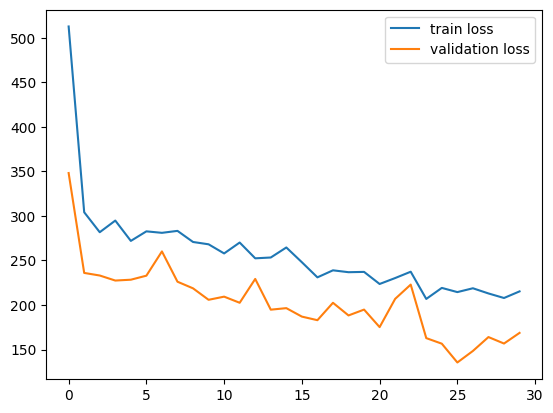

In [14]:
#plot history
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="validation loss")
plt.legend()
plt.show()